# Hourly Bike Rental Prediction

### Importing all necessary libraries

In [115]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math

### Reading data and dropping less important 

In [116]:

maindata = pd.read_csv("hour.csv")
bikes_prep = maindata.copy()




In [117]:

bikes_prep.isnull().sum()

index         0
date          0
season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
demand        0
dtype: int64

In [118]:
bikes_prep = bikes_prep.drop(['index', 'date', 'casual', 'registered'], axis=1)

### Plotting Histograms to see distribution of various features

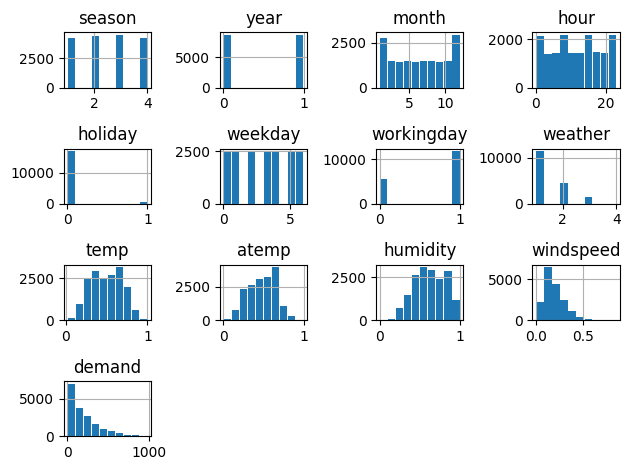

In [119]:

bikes_prep.hist(rwidth =0.9)
plt.tight_layout()


##### Observation
Demand has to be normalised

### Plotting graphs to observe dependence of Demand with various Features

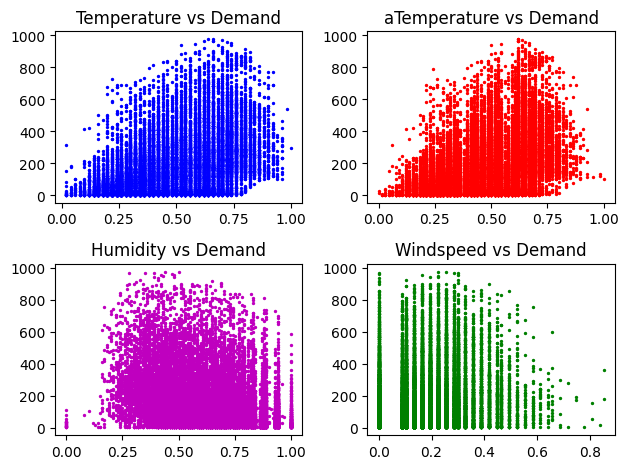

In [120]:
plt.subplot(2,2,1)
plt.title("Temperature vs Demand")
plt.scatter(bikes_prep["temp"], bikes_prep["demand"], s=2, c='b')

plt.subplot(2,2,2)
plt.title("aTemperature vs Demand")
plt.scatter(bikes_prep["atemp"], bikes_prep["demand"], s=2, c='r')

plt.subplot(2,2,3)
plt.title("Humidity vs Demand")
plt.scatter(bikes_prep["humidity"], bikes_prep["demand"], s=2, c='m')

plt.subplot(2,2,4)
plt.title("Windspeed vs Demand")
plt.scatter(bikes_prep["windspeed"], bikes_prep["demand"], s=2, c='g')
plt.tight_layout()



#### Observation
 possibility of High corelation between Temp and aTemp

### Plotting Categorical features vs Demand

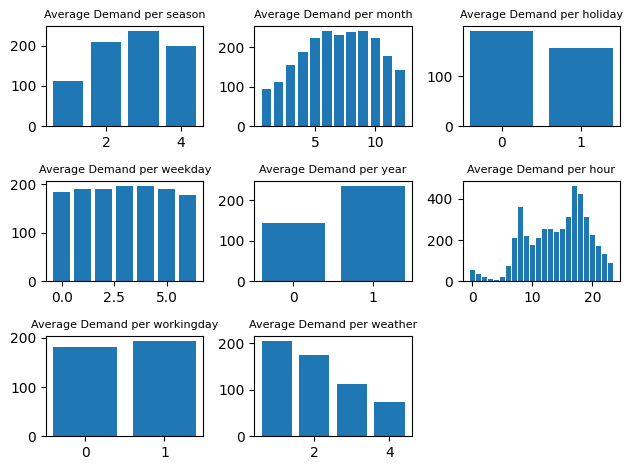

In [121]:

colums = ["season", "month", "holiday", "weekday", "year", "hour", "workingday", "weather"]
for x in colums:
    list = bikes_prep[x].unique()
    average = bikes_prep.groupby(x).mean()['demand']
    plt.subplot(3,3,colums.index(x)+1)
    plt.bar(list, average)
    title = "Average Demand per " + x
    plt.title(title, fontsize = 8)

plt.tight_layout()



 Low dependence of demand on weekday ,year(because demand might increase due to more awareness), working day

### checking outliers

In [122]:
bikes_prep['demand'].describe()

bikes_prep['demand'].quantile([0.05, 0.1, 0.15, 0.5, 0.9, 0.95, 0.99])

0.05      5.00
0.10      9.00
0.15     16.00
0.50    142.00
0.90    451.20
0.95    563.10
0.99    782.22
Name: demand, dtype: float64

### Testing Multicolinearity among features


In [123]:

correlation = bikes_prep[['temp','atemp', 'humidity', 'windspeed', 'demand']].corr()
print(correlation)


               temp     atemp  humidity  windspeed    demand
temp       1.000000  0.987672 -0.069881  -0.023125  0.404772
atemp      0.987672  1.000000 -0.051918  -0.062336  0.400929
humidity  -0.069881 -0.051918  1.000000  -0.290105 -0.322911
windspeed -0.023125 -0.062336 -0.290105   1.000000  0.093234
demand     0.404772  0.400929 -0.322911   0.093234  1.000000


### Observation
Near perfect correlation between temp and atemp.

almost no correlation between wind speed and demand

In [124]:
bikes_prep = bikes_prep.drop(['atemp', 'windspeed', 'weekday', 'year', 'workingday'], axis = 1)

bikes_prep.head()

,season,month,hour,holiday,weather,temp,humidity,demand
0,1,1,0,0,1,0.24,0.81,16
1,1,1,1,0,1,0.22,0.80,40
2,1,1,2,0,1,0.22,0.80,32
3,1,1,3,0,1,0.24,0.75,13
4,1,1,4,0,1,0.24,0.75,1


Drop atemp and Windspeed, also weekday, year, working day

thus we reduced 17 coulmns to 8

### Checking for Auto correlation

(array([-12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
          1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12]),
 array([0.45474795, 0.47049642, 0.49622893, 0.49404147, 0.46796018,
        0.47732133, 0.5267586 , 0.59145856, 0.65201694, 0.7151968 ,
        0.8059117 , 0.9253113 , 1.        , 0.9253113 , 0.8059117 ,
        0.7151968 , 0.65201694, 0.59145856, 0.5267586 , 0.47732133,
        0.46796018, 0.49404147, 0.49622893, 0.47049642, 0.45474795],
       dtype=float32),
 <matplotlib.lines.Line2D at 0x21605d59820>)

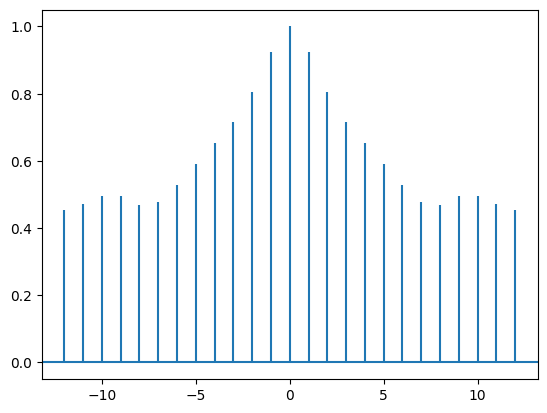

In [125]:
df1 = pd.to_numeric(bikes_prep['demand'], downcast='float')
plt.acorr(df1, maxlags = 12)

### Observation
Top 3 correlations are signifinactly high

High correlation exists for demand

#### Normalising Demand 

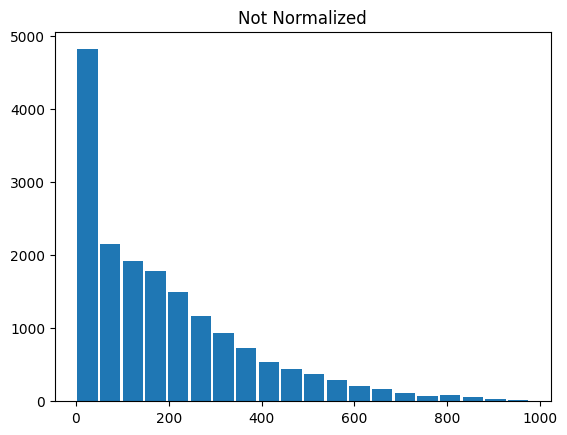

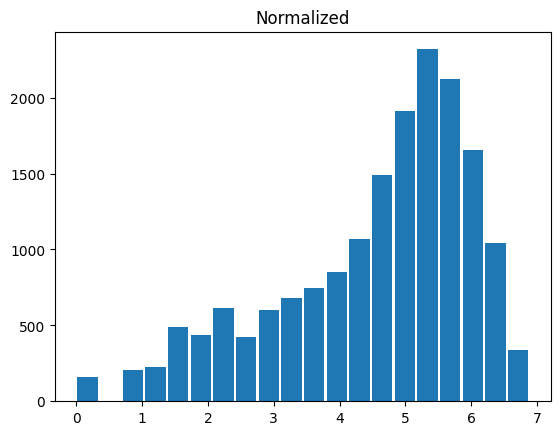

In [126]:
df1= bikes_prep['demand']
df2 = np.log(df1)
plt.figure()
plt.hist(df1, rwidth=0.9, bins =20)
plt.title("Not Normalized")

plt.figure()
plt.hist(df2, rwidth=0.9, bins = 20)
plt.title("Normalized")
bikes_prep['demand'] = np.log(bikes_prep['demand'])

### Fixing Autocorrelation among Demand

In [127]:

t_1 = bikes_prep['demand'].shift(+1).to_frame()
t_1.columns = ["t_1"]
t_2 = bikes_prep['demand'].shift(+2).to_frame()
t_2.columns = ["t_2"]
t_3 = bikes_prep['demand'].shift(+3).to_frame()
t_3.columns = ["t_3"]
bikes_prep_lag = pd.concat([bikes_prep, t_1, t_2, t_3], axis=1)
bikes_prep_lag = bikes_prep_lag.dropna()

bikes_prep_lag.head()

,season,month,hour,holiday,weather,temp,humidity,demand,t_1,t_2,t_3
3,1,1,3,0,1,0.24,0.75,2.564949,3.465736,3.688879,2.772589
4,1,1,4,0,1,0.24,0.75,0.000000,2.564949,3.465736,3.688879
5,1,1,5,0,2,0.24,0.75,0.000000,0.000000,2.564949,3.465736
6,1,1,6,0,1,0.22,0.80,0.693147,0.000000,0.000000,2.564949
7,1,1,7,0,1,0.20,0.86,1.098612,0.693147,0.000000,0.000000


### Converting requred features' type to Categorical

In [128]:

bikes_prep_lag.dtypes

bikes_prep_lag['season'] = bikes_prep_lag['season'].astype('category')
bikes_prep_lag['month'] = bikes_prep_lag['month'].astype('category')
bikes_prep_lag['hour'] = bikes_prep_lag['hour'].astype('category')
bikes_prep_lag['weather'] = bikes_prep_lag['weather'].astype('category')
bikes_prep_lag['holiday'] = bikes_prep_lag['holiday'].astype('category')

bikes_prep_lag = pd.get_dummies(bikes_prep_lag, drop_first=True)

bikes_prep_lag.head()


,temp,humidity,demand,t_1,t_2,t_3,season_2,season_3,season_4,month_2,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday_1,weather_2,weather_3,weather_4
3,0.24,0.75,2.564949,3.465736,3.688879,2.772589,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.24,0.75,0.000000,2.564949,3.465736,3.688879,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,0.24,0.75,0.000000,0.000000,2.564949,3.465736,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
6,0.22,0.80,0.693147,0.000000,0.000000,2.564949,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,0.20,0.86,1.098612,0.693147,0.000000,0.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Creating test and train data

In [129]:
Y = bikes_prep_lag[['demand']]
X = bikes_prep_lag.drop(['demand'], axis=1)

length = 0.9
trainsize = int(length*len(X))

X_train = X.values[0:trainsize]
Y_train = Y.values[0:trainsize] 
X_test = X.values[trainsize:len(X)]
Y_test = Y.values[trainsize:len(X)]

### Creating a Linear Regression model

In [130]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
 
r2_train = regressor.score(X_train, Y_train)
r2_test = regressor.score(X_test, Y_test)
Y_predicted = pd.DataFrame()
Y_predicted = regressor.predict(X_test)

### Calculating RMSE

In [131]:
from sklearn.metrics import mean_squared_error
rmse   = math.sqrt(mean_squared_error(Y_test, Y_predicted))
print("RMSE: ")
print(rmse)

RMSE: 
0.4062287605380681


### Calculating RMSLE

In [132]:
#calculating RMSLE

Y_test_e = []
Y_predicted_e = []
for i in range(0, len(X_test)):
    Y_test_e.append(math.exp(Y_test[i]))
    Y_predicted_e.append(math.exp(Y_predicted[i]))

differencesquare = 0.0
for i in range(0, len(Y_test)):
    log_a = math.log(Y_test_e[i] +1)
    log_p = math.log(Y_predicted_e[i] +1)
    difference = log_p-log_a
    differencesquare = differencesquare + difference**2

rmsle = math.sqrt(differencesquare/len(Y_test))
print("RMSLE: ")
print(rmsle)


RMSLE: 
0.3665498821563867


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16220\1451476187.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_test_e.append(math.exp(Y_test[i]))
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16220\1451476187.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_predicted_e.append(math.exp(Y_predicted[i]))


with this decent score lets save the predictions

In [133]:
prediction = pd.DataFrame()
prediction['count'] = np.round(Y_predicted_e)
prediction.to_csv('Prediction.csv', header=True, index =False)